# Miller age

In [1]:
ood_seed = 6

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Hub cells', '11.5'), 218)


Removed datapoint: 218

train         5793
validation    1394
ood            218
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 100754.29it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 959227.31it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 205.89it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<21:05,  3.17s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<21:05,  3.17s/it, v_num=1, recon=1.18e+3, r2_mean=0.0607, adv_loss=3.39, acc_pert=0.325, acc_integration_donor=0.159]

Epoch 2/400:   0%|          | 1/400 [00:03<21:05,  3.17s/it, v_num=1, recon=1.18e+3, r2_mean=0.0607, adv_loss=3.39, acc_pert=0.325, acc_integration_donor=0.159]

Epoch 2/400:   0%|          | 2/400 [00:05<18:54,  2.85s/it, v_num=1, recon=1.18e+3, r2_mean=0.0607, adv_loss=3.39, acc_pert=0.325, acc_integration_donor=0.159]

Epoch 2/400:   0%|          | 2/400 [00:05<18:54,  2.85s/it, v_num=1, recon=993, r2_mean=0.289, adv_loss=2.95, acc_pert=0.46, acc_integration_donor=0.398]      

Epoch 3/400:   0%|          | 2/400 [00:05<18:54,  2.85s/it, v_num=1, recon=993, r2_mean=0.289, adv_loss=2.95, acc_pert=0.46, acc_integration_donor=0.398]

Epoch 3/400:   1%|          | 3/400 [00:08<18:26,  2.79s/it, v_num=1, recon=993, r2_mean=0.289, adv_loss=2.95, acc_pert=0.46, acc_integration_donor=0.398]

Epoch 3/400:   1%|          | 3/400 [00:08<18:26,  2.79s/it, v_num=1, recon=927, r2_mean=0.38, adv_loss=2.63, acc_pert=0.545, acc_integration_donor=0.476]

Epoch 4/400:   1%|          | 3/400 [00:08<18:26,  2.79s/it, v_num=1, recon=927, r2_mean=0.38, adv_loss=2.63, acc_pert=0.545, acc_integration_donor=0.476]

Epoch 4/400:   1%|          | 4/400 [00:11<17:50,  2.70s/it, v_num=1, recon=927, r2_mean=0.38, adv_loss=2.63, acc_pert=0.545, acc_integration_donor=0.476]

Epoch 4/400:   1%|          | 4/400 [00:11<17:50,  2.70s/it, v_num=1, recon=890, r2_mean=0.431, adv_loss=2.42, acc_pert=0.565, acc_integration_donor=0.516]

Epoch 5/400:   1%|          | 4/400 [00:11<17:50,  2.70s/it, v_num=1, recon=890, r2_mean=0.431, adv_loss=2.42, acc_pert=0.565, acc_integration_donor=0.516]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:33,  2.67s/it, v_num=1, recon=890, r2_mean=0.431, adv_loss=2.42, acc_pert=0.565, acc_integration_donor=0.516]

Epoch 5/400:   1%|▏         | 5/400 [00:13<17:33,  2.67s/it, v_num=1, recon=872, r2_mean=0.451, adv_loss=2.29, acc_pert=0.567, acc_integration_donor=0.546]

Epoch 6/400:   1%|▏         | 5/400 [00:13<17:33,  2.67s/it, v_num=1, recon=872, r2_mean=0.451, adv_loss=2.29, acc_pert=0.567, acc_integration_donor=0.546]

Epoch 6/400:   2%|▏         | 6/400 [00:16<17:21,  2.64s/it, v_num=1, recon=872, r2_mean=0.451, adv_loss=2.29, acc_pert=0.567, acc_integration_donor=0.546]

Epoch 6/400:   2%|▏         | 6/400 [00:16<17:21,  2.64s/it, v_num=1, recon=861, r2_mean=0.455, adv_loss=2.19, acc_pert=0.599, acc_integration_donor=0.564]

Epoch 7/400:   2%|▏         | 6/400 [00:16<17:21,  2.64s/it, v_num=1, recon=861, r2_mean=0.455, adv_loss=2.19, acc_pert=0.599, acc_integration_donor=0.564]

Epoch 7/400:   2%|▏         | 7/400 [00:18<17:20,  2.65s/it, v_num=1, recon=861, r2_mean=0.455, adv_loss=2.19, acc_pert=0.599, acc_integration_donor=0.564]

Epoch 7/400:   2%|▏         | 7/400 [00:18<17:20,  2.65s/it, v_num=1, recon=854, r2_mean=0.463, adv_loss=2.17, acc_pert=0.586, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 7/400 [00:18<17:20,  2.65s/it, v_num=1, recon=854, r2_mean=0.463, adv_loss=2.17, acc_pert=0.586, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 8/400 [00:21<17:22,  2.66s/it, v_num=1, recon=854, r2_mean=0.463, adv_loss=2.17, acc_pert=0.586, acc_integration_donor=0.566]

Epoch 8/400:   2%|▏         | 8/400 [00:21<17:22,  2.66s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.557]

Epoch 9/400:   2%|▏         | 8/400 [00:21<17:22,  2.66s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.557]

Epoch 9/400:   2%|▏         | 9/400 [00:24<17:10,  2.64s/it, v_num=1, recon=846, r2_mean=0.469, adv_loss=2.15, acc_pert=0.585, acc_integration_donor=0.557]

Epoch 9/400:   2%|▏         | 9/400 [00:24<17:10,  2.64s/it, v_num=1, recon=842, r2_mean=0.476, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.561]

Epoch 10/400:   2%|▏         | 9/400 [00:24<17:10,  2.64s/it, v_num=1, recon=842, r2_mean=0.476, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.561]


disnt_basal = 0.5594075816574541

disnt_after = 0.989343440800604

val_r2_mean = 0.5235725741881828

val_r2_var = 0.22130533936735872


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:37<37:59,  5.84s/it, v_num=1, recon=842, r2_mean=0.476, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.561]

Epoch 10/400:   2%|▎         | 10/400 [00:37<37:59,  5.84s/it, v_num=1, recon=836, r2_mean=0.484, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.537, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:37<37:59,  5.84s/it, v_num=1, recon=836, r2_mean=0.484, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.537, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<31:40,  4.89s/it, v_num=1, recon=836, r2_mean=0.484, adv_loss=2.15, acc_pert=0.576, acc_integration_donor=0.537, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:39<31:40,  4.89s/it, v_num=1, recon=833, r2_mean=0.486, adv_loss=2.12, acc_pert=0.585, acc_integration_donor=0.542, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:39<31:40,  4.89s/it, v_num=1, recon=833, r2_mean=0.486, adv_loss=2.12, acc_pert=0.585, acc_integration_donor=0.542, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:42<27:35,  4.27s/it, v_num=1, recon=833, r2_mean=0.486, adv_loss=2.12, acc_pert=0.585, acc_integration_donor=0.542, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:42<27:35,  4.27s/it, v_num=1, recon=827, r2_mean=0.493, adv_loss=2.14, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [00:42<27:35,  4.27s/it, v_num=1, recon=827, r2_mean=0.493, adv_loss=2.14, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:45<24:18,  3.77s/it, v_num=1, recon=827, r2_mean=0.493, adv_loss=2.14, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:45<24:18,  3.77s/it, v_num=1, recon=826, r2_mean=0.5, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]  

Epoch 14/400:   3%|▎         | 13/400 [00:45<24:18,  3.77s/it, v_num=1, recon=826, r2_mean=0.5, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:48<22:12,  3.45s/it, v_num=1, recon=826, r2_mean=0.5, adv_loss=2.13, acc_pert=0.579, acc_integration_donor=0.528, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:48<22:12,  3.45s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.14, acc_pert=0.582, acc_integration_donor=0.52, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:48<22:12,  3.45s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.14, acc_pert=0.582, acc_integration_donor=0.52, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:50<20:37,  3.21s/it, v_num=1, recon=822, r2_mean=0.497, adv_loss=2.14, acc_pert=0.582, acc_integration_donor=0.52, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:50<20:37,  3.21s/it, v_num=1, recon=820, r2_mean=0.505, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.524, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [00:50<20:37,  3.21s/it, v_num=1, recon=820, r2_mean=0.505, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.524, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:53<19:30,  3.05s/it, v_num=1, recon=820, r2_mean=0.505, adv_loss=2.15, acc_pert=0.579, acc_integration_donor=0.524, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:53<19:30,  3.05s/it, v_num=1, recon=816, r2_mean=0.51, adv_loss=2.17, acc_pert=0.573, acc_integration_donor=0.515, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [00:53<19:30,  3.05s/it, v_num=1, recon=816, r2_mean=0.51, adv_loss=2.17, acc_pert=0.573, acc_integration_donor=0.515, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:56<18:44,  2.94s/it, v_num=1, recon=816, r2_mean=0.51, adv_loss=2.17, acc_pert=0.573, acc_integration_donor=0.515, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:56<18:44,  2.94s/it, v_num=1, recon=814, r2_mean=0.51, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:56<18:44,  2.94s/it, v_num=1, recon=814, r2_mean=0.51, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:58<18:03,  2.84s/it, v_num=1, recon=814, r2_mean=0.51, adv_loss=2.18, acc_pert=0.565, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:58<18:03,  2.84s/it, v_num=1, recon=811, r2_mean=0.507, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.517, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [00:58<18:03,  2.84s/it, v_num=1, recon=811, r2_mean=0.507, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.517, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:01<17:33,  2.77s/it, v_num=1, recon=811, r2_mean=0.507, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.517, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [01:01<17:33,  2.77s/it, v_num=1, recon=814, r2_mean=0.512, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [01:01<17:33,  2.77s/it, v_num=1, recon=814, r2_mean=0.512, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.5392528780746947

disnt_after = 0.9606384131180051

val_r2_mean = 0.5268623700196092

val_r2_var = 0.3295422894033519


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:10<30:13,  4.77s/it, v_num=1, recon=814, r2_mean=0.512, adv_loss=2.17, acc_pert=0.569, acc_integration_donor=0.519, val_recon=860, disnt_basal=0.559, disnt_after=0.989, val_r2_mean=0.524, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:10<30:13,  4.77s/it, v_num=1, recon=811, r2_mean=0.517, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:10<30:13,  4.77s/it, v_num=1, recon=811, r2_mean=0.517, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<26:10,  4.14s/it, v_num=1, recon=811, r2_mean=0.517, adv_loss=2.15, acc_pert=0.574, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:13<26:10,  4.14s/it, v_num=1, recon=810, r2_mean=0.518, adv_loss=2.14, acc_pert=0.569, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [01:13<26:10,  4.14s/it, v_num=1, recon=810, r2_mean=0.518, adv_loss=2.14, acc_pert=0.569, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:16<23:06,  3.67s/it, v_num=1, recon=810, r2_mean=0.518, adv_loss=2.14, acc_pert=0.569, acc_integration_donor=0.522, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:16<23:06,  3.67s/it, v_num=1, recon=805, r2_mean=0.525, adv_loss=2.16, acc_pert=0.573, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:16<23:06,  3.67s/it, v_num=1, recon=805, r2_mean=0.525, adv_loss=2.16, acc_pert=0.573, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<21:01,  3.35s/it, v_num=1, recon=805, r2_mean=0.525, adv_loss=2.16, acc_pert=0.573, acc_integration_donor=0.527, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:18<21:01,  3.35s/it, v_num=1, recon=805, r2_mean=0.52, adv_loss=2.13, acc_pert=0.574, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan] 

Epoch 24/400:   6%|▌         | 23/400 [01:18<21:01,  3.35s/it, v_num=1, recon=805, r2_mean=0.52, adv_loss=2.13, acc_pert=0.574, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<19:32,  3.12s/it, v_num=1, recon=805, r2_mean=0.52, adv_loss=2.13, acc_pert=0.574, acc_integration_donor=0.525, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:21<19:32,  3.12s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.15, acc_pert=0.57, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:21<19:32,  3.12s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.15, acc_pert=0.57, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<18:28,  2.96s/it, v_num=1, recon=803, r2_mean=0.525, adv_loss=2.15, acc_pert=0.57, acc_integration_donor=0.514, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:23<18:28,  2.96s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan] 

Epoch 26/400:   6%|▋         | 25/400 [01:23<18:28,  2.96s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<17:38,  2.83s/it, v_num=1, recon=803, r2_mean=0.53, adv_loss=2.15, acc_pert=0.572, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:26<17:38,  2.83s/it, v_num=1, recon=802, r2_mean=0.525, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:26<17:38,  2.83s/it, v_num=1, recon=802, r2_mean=0.525, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:28<17:00,  2.74s/it, v_num=1, recon=802, r2_mean=0.525, adv_loss=2.16, acc_pert=0.565, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:28<17:00,  2.74s/it, v_num=1, recon=798, r2_mean=0.526, adv_loss=2.16, acc_pert=0.571, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:28<17:00,  2.74s/it, v_num=1, recon=798, r2_mean=0.526, adv_loss=2.16, acc_pert=0.571, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<16:38,  2.68s/it, v_num=1, recon=798, r2_mean=0.526, adv_loss=2.16, acc_pert=0.571, acc_integration_donor=0.526, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:31<16:38,  2.68s/it, v_num=1, recon=799, r2_mean=0.528, adv_loss=2.16, acc_pert=0.564, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [01:31<16:38,  2.68s/it, v_num=1, recon=799, r2_mean=0.528, adv_loss=2.16, acc_pert=0.564, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:33<16:23,  2.65s/it, v_num=1, recon=799, r2_mean=0.528, adv_loss=2.16, acc_pert=0.564, acc_integration_donor=0.517, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:33<16:23,  2.65s/it, v_num=1, recon=798, r2_mean=0.535, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan] 

Epoch 30/400:   7%|▋         | 29/400 [01:33<16:23,  2.65s/it, v_num=1, recon=798, r2_mean=0.535, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.5249609992013504

disnt_after = 0.9127982150651274

val_r2_mean = 0.524440972642465

val_r2_var = 0.3671408092433756

Epoch 30/400:   8%|▊         | 30/400 [01:50<41:45,  6.77s/it, v_num=1, recon=798, r2_mean=0.535, adv_loss=2.15, acc_pert=0.558, acc_integration_donor=0.52, val_recon=836, disnt_basal=0.539, disnt_after=0.961, val_r2_mean=0.527, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:50<41:45,  6.77s/it, v_num=1, recon=796, r2_mean=0.532, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:50<41:45,  6.77s/it, v_num=1, recon=796, r2_mean=0.532, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:54<36:43,  5.97s/it, v_num=1, recon=796, r2_mean=0.532, adv_loss=2.15, acc_pert=0.554, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:54<36:43,  5.97s/it, v_num=1, recon=794, r2_mean=0.538, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.516, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:54<36:43,  5.97s/it, v_num=1, recon=794, r2_mean=0.538, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.516, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:57<31:07,  5.08s/it, v_num=1, recon=794, r2_mean=0.538, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.516, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:57<31:07,  5.08s/it, v_num=1, recon=792, r2_mean=0.54, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:57<31:07,  5.08s/it, v_num=1, recon=792, r2_mean=0.54, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:00<26:31,  4.34s/it, v_num=1, recon=792, r2_mean=0.54, adv_loss=2.17, acc_pert=0.547, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [02:00<26:31,  4.34s/it, v_num=1, recon=790, r2_mean=0.532, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.523, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [02:00<26:31,  4.34s/it, v_num=1, recon=790, r2_mean=0.532, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.523, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:02<23:23,  3.84s/it, v_num=1, recon=790, r2_mean=0.532, adv_loss=2.17, acc_pert=0.562, acc_integration_donor=0.523, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [02:02<23:23,  3.84s/it, v_num=1, recon=789, r2_mean=0.534, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.515, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [02:02<23:23,  3.84s/it, v_num=1, recon=789, r2_mean=0.534, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.515, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:05<22:03,  3.62s/it, v_num=1, recon=789, r2_mean=0.534, adv_loss=2.17, acc_pert=0.566, acc_integration_donor=0.515, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [02:05<22:03,  3.62s/it, v_num=1, recon=789, r2_mean=0.541, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [02:05<22:03,  3.62s/it, v_num=1, recon=789, r2_mean=0.541, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:08<20:15,  3.34s/it, v_num=1, recon=789, r2_mean=0.541, adv_loss=2.19, acc_pert=0.551, acc_integration_donor=0.526, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:08<20:15,  3.34s/it, v_num=1, recon=788, r2_mean=0.544, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [02:08<20:15,  3.34s/it, v_num=1, recon=788, r2_mean=0.544, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:11<19:57,  3.30s/it, v_num=1, recon=788, r2_mean=0.544, adv_loss=2.18, acc_pert=0.549, acc_integration_donor=0.522, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:11<19:57,  3.30s/it, v_num=1, recon=788, r2_mean=0.54, adv_loss=2.2, acc_pert=0.551, acc_integration_donor=0.518, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]  

Epoch 38/400:   9%|▉         | 37/400 [02:11<19:57,  3.30s/it, v_num=1, recon=788, r2_mean=0.54, adv_loss=2.2, acc_pert=0.551, acc_integration_donor=0.518, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:14<18:37,  3.09s/it, v_num=1, recon=788, r2_mean=0.54, adv_loss=2.2, acc_pert=0.551, acc_integration_donor=0.518, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:14<18:37,  3.09s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:14<18:37,  3.09s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:17<17:50,  2.96s/it, v_num=1, recon=784, r2_mean=0.54, adv_loss=2.2, acc_pert=0.552, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:17<17:50,  2.96s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:17<17:50,  2.96s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.509753617605968

disnt_after = 0.9201442682343177

val_r2_mean = 0.5197921456261114

val_r2_var = 0.388441991399635


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:25<27:34,  4.60s/it, v_num=1, recon=785, r2_mean=0.541, adv_loss=2.22, acc_pert=0.547, acc_integration_donor=0.519, val_recon=828, disnt_basal=0.525, disnt_after=0.913, val_r2_mean=0.524, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:25<27:34,  4.60s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]    

Epoch 41/400:  10%|█         | 40/400 [02:25<27:34,  4.60s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:28<23:58,  4.01s/it, v_num=1, recon=786, r2_mean=0.542, adv_loss=2.2, acc_pert=0.541, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:28<23:58,  4.01s/it, v_num=1, recon=786, r2_mean=0.548, adv_loss=2.2, acc_pert=0.542, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan] 

Epoch 42/400:  10%|█         | 41/400 [02:28<23:58,  4.01s/it, v_num=1, recon=786, r2_mean=0.548, adv_loss=2.2, acc_pert=0.542, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:30<21:18,  3.57s/it, v_num=1, recon=786, r2_mean=0.548, adv_loss=2.2, acc_pert=0.542, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:30<21:18,  3.57s/it, v_num=1, recon=785, r2_mean=0.547, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:30<21:18,  3.57s/it, v_num=1, recon=785, r2_mean=0.547, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:34<22:18,  3.75s/it, v_num=1, recon=785, r2_mean=0.547, adv_loss=2.21, acc_pert=0.558, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:34<22:18,  3.75s/it, v_num=1, recon=781, r2_mean=0.546, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan] 

Epoch 44/400:  11%|█         | 43/400 [02:34<22:18,  3.75s/it, v_num=1, recon=781, r2_mean=0.546, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:37<20:07,  3.39s/it, v_num=1, recon=781, r2_mean=0.546, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:37<20:07,  3.39s/it, v_num=1, recon=780, r2_mean=0.547, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:37<20:07,  3.39s/it, v_num=1, recon=780, r2_mean=0.547, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:39<18:32,  3.13s/it, v_num=1, recon=780, r2_mean=0.547, adv_loss=2.18, acc_pert=0.546, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:39<18:32,  3.13s/it, v_num=1, recon=779, r2_mean=0.556, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:39<18:32,  3.13s/it, v_num=1, recon=779, r2_mean=0.556, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:42<17:35,  2.98s/it, v_num=1, recon=779, r2_mean=0.556, adv_loss=2.18, acc_pert=0.559, acc_integration_donor=0.526, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:42<17:35,  2.98s/it, v_num=1, recon=779, r2_mean=0.548, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [02:42<17:35,  2.98s/it, v_num=1, recon=779, r2_mean=0.548, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:45<16:50,  2.86s/it, v_num=1, recon=779, r2_mean=0.548, adv_loss=2.21, acc_pert=0.538, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:45<16:50,  2.86s/it, v_num=1, recon=779, r2_mean=0.547, adv_loss=2.2, acc_pert=0.559, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [02:45<16:50,  2.86s/it, v_num=1, recon=779, r2_mean=0.547, adv_loss=2.2, acc_pert=0.559, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:47<16:17,  2.78s/it, v_num=1, recon=779, r2_mean=0.547, adv_loss=2.2, acc_pert=0.559, acc_integration_donor=0.527, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:47<16:17,  2.78s/it, v_num=1, recon=777, r2_mean=0.548, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:47<16:17,  2.78s/it, v_num=1, recon=777, r2_mean=0.548, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:50<16:00,  2.74s/it, v_num=1, recon=777, r2_mean=0.548, adv_loss=2.2, acc_pert=0.548, acc_integration_donor=0.525, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:50<16:00,  2.74s/it, v_num=1, recon=777, r2_mean=0.552, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [02:50<16:00,  2.74s/it, v_num=1, recon=777, r2_mean=0.552, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]


disnt_basal = 0.5023839131761247

disnt_after = 0.9479984743243925

val_r2_mean = 0.5270852900364182

val_r2_var = 0.3904017765413631


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [03:07<40:47,  6.99s/it, v_num=1, recon=777, r2_mean=0.552, adv_loss=2.2, acc_pert=0.555, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.51, disnt_after=0.92, val_r2_mean=0.52, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [03:07<40:47,  6.99s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [03:07<40:47,  6.99s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:09<33:08,  5.70s/it, v_num=1, recon=776, r2_mean=0.55, adv_loss=2.18, acc_pert=0.547, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [03:09<33:08,  5.70s/it, v_num=1, recon=776, r2_mean=0.555, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [03:09<33:08,  5.70s/it, v_num=1, recon=776, r2_mean=0.555, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:12<28:08,  4.85s/it, v_num=1, recon=776, r2_mean=0.555, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [03:12<28:08,  4.85s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.53, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]   

Epoch 53/400:  13%|█▎        | 52/400 [03:12<28:08,  4.85s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.53, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:15<24:10,  4.18s/it, v_num=1, recon=775, r2_mean=0.55, adv_loss=2.21, acc_pert=0.54, acc_integration_donor=0.53, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [03:15<24:10,  4.18s/it, v_num=1, recon=773, r2_mean=0.558, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [03:15<24:10,  4.18s/it, v_num=1, recon=773, r2_mean=0.558, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:18<22:24,  3.88s/it, v_num=1, recon=773, r2_mean=0.558, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [03:18<22:24,  3.88s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [03:18<22:24,  3.88s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:21<20:06,  3.50s/it, v_num=1, recon=774, r2_mean=0.554, adv_loss=2.23, acc_pert=0.542, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [03:21<20:06,  3.50s/it, v_num=1, recon=772, r2_mean=0.555, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.524, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [03:21<20:06,  3.50s/it, v_num=1, recon=772, r2_mean=0.555, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.524, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:23<18:26,  3.22s/it, v_num=1, recon=772, r2_mean=0.555, adv_loss=2.23, acc_pert=0.544, acc_integration_donor=0.524, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [03:23<18:26,  3.22s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [03:23<18:26,  3.22s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:26<17:16,  3.02s/it, v_num=1, recon=770, r2_mean=0.556, adv_loss=2.22, acc_pert=0.527, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:26<17:16,  3.02s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:26<17:16,  3.02s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:28<16:35,  2.91s/it, v_num=1, recon=766, r2_mean=0.557, adv_loss=2.22, acc_pert=0.544, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:28<16:35,  2.91s/it, v_num=1, recon=767, r2_mean=0.555, adv_loss=2.24, acc_pert=0.53, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan] 

Epoch 59/400:  14%|█▍        | 58/400 [03:28<16:35,  2.91s/it, v_num=1, recon=767, r2_mean=0.555, adv_loss=2.24, acc_pert=0.53, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:31<16:07,  2.84s/it, v_num=1, recon=767, r2_mean=0.555, adv_loss=2.24, acc_pert=0.53, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:31<16:07,  2.84s/it, v_num=1, recon=768, r2_mean=0.562, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [03:31<16:07,  2.84s/it, v_num=1, recon=768, r2_mean=0.562, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]


disnt_basal = 0.4932458893463423

disnt_after = 0.9545078790328525

val_r2_mean = 0.5255214714191176

val_r2_var = 0.39414183727719565


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [03:47<38:23,  6.77s/it, v_num=1, recon=768, r2_mean=0.562, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.502, disnt_after=0.948, val_r2_mean=0.527, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:47<38:23,  6.77s/it, v_num=1, recon=765, r2_mean=0.555, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [03:47<38:23,  6.77s/it, v_num=1, recon=765, r2_mean=0.555, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:50<31:55,  5.65s/it, v_num=1, recon=765, r2_mean=0.555, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:50<31:55,  5.65s/it, v_num=1, recon=766, r2_mean=0.56, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan] 

Epoch 62/400:  15%|█▌        | 61/400 [03:50<31:55,  5.65s/it, v_num=1, recon=766, r2_mean=0.56, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:53<26:40,  4.74s/it, v_num=1, recon=766, r2_mean=0.56, adv_loss=2.25, acc_pert=0.534, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:53<26:40,  4.74s/it, v_num=1, recon=764, r2_mean=0.56, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:53<26:40,  4.74s/it, v_num=1, recon=764, r2_mean=0.56, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:55<22:57,  4.09s/it, v_num=1, recon=764, r2_mean=0.56, adv_loss=2.25, acc_pert=0.533, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:55<22:57,  4.09s/it, v_num=1, recon=765, r2_mean=0.56, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [03:55<22:57,  4.09s/it, v_num=1, recon=765, r2_mean=0.56, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:58<20:18,  3.63s/it, v_num=1, recon=765, r2_mean=0.56, adv_loss=2.28, acc_pert=0.523, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:58<20:18,  3.63s/it, v_num=1, recon=767, r2_mean=0.561, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:58<20:18,  3.63s/it, v_num=1, recon=767, r2_mean=0.561, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [04:00<18:34,  3.33s/it, v_num=1, recon=767, r2_mean=0.561, adv_loss=2.28, acc_pert=0.533, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [04:00<18:34,  3.33s/it, v_num=1, recon=765, r2_mean=0.565, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [04:00<18:34,  3.33s/it, v_num=1, recon=765, r2_mean=0.565, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [04:03<17:20,  3.12s/it, v_num=1, recon=765, r2_mean=0.565, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [04:03<17:20,  3.12s/it, v_num=1, recon=766, r2_mean=0.562, adv_loss=2.26, acc_pert=0.519, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [04:03<17:20,  3.12s/it, v_num=1, recon=766, r2_mean=0.562, adv_loss=2.26, acc_pert=0.519, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [04:06<16:36,  2.99s/it, v_num=1, recon=766, r2_mean=0.562, adv_loss=2.26, acc_pert=0.519, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [04:06<16:36,  2.99s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.531, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [04:06<16:36,  2.99s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.531, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [04:08<15:47,  2.85s/it, v_num=1, recon=763, r2_mean=0.561, adv_loss=2.24, acc_pert=0.525, acc_integration_donor=0.531, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [04:08<15:47,  2.85s/it, v_num=1, recon=762, r2_mean=0.562, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [04:08<15:47,  2.85s/it, v_num=1, recon=762, r2_mean=0.562, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:11<15:15,  2.77s/it, v_num=1, recon=762, r2_mean=0.562, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.522, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [04:11<15:15,  2.77s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [04:11<15:15,  2.77s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]


disnt_basal = 0.4927657990938333

disnt_after = 0.9548399437189005

val_r2_mean = 0.5208287929946726

val_r2_var = 0.3957564227960326

Epoch 70/400:  18%|█▊        | 70/400 [04:25<33:43,  6.13s/it, v_num=1, recon=760, r2_mean=0.559, adv_loss=2.23, acc_pert=0.539, acc_integration_donor=0.527, val_recon=822, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.526, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [04:25<33:43,  6.13s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [04:25<33:43,  6.13s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:27<27:49,  5.07s/it, v_num=1, recon=759, r2_mean=0.565, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:27<27:49,  5.07s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.514, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [04:27<27:49,  5.07s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.514, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:30<23:39,  4.33s/it, v_num=1, recon=759, r2_mean=0.566, adv_loss=2.26, acc_pert=0.524, acc_integration_donor=0.514, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:30<23:39,  4.33s/it, v_num=1, recon=757, r2_mean=0.563, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:30<23:39,  4.33s/it, v_num=1, recon=757, r2_mean=0.563, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:33<20:45,  3.81s/it, v_num=1, recon=757, r2_mean=0.563, adv_loss=2.25, acc_pert=0.524, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:33<20:45,  3.81s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.53, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [04:33<20:45,  3.81s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.53, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:35<18:40,  3.44s/it, v_num=1, recon=758, r2_mean=0.566, adv_loss=2.24, acc_pert=0.533, acc_integration_donor=0.53, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:35<18:40,  3.44s/it, v_num=1, recon=755, r2_mean=0.57, adv_loss=2.25, acc_pert=0.535, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [04:35<18:40,  3.44s/it, v_num=1, recon=755, r2_mean=0.57, adv_loss=2.25, acc_pert=0.535, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:38<17:13,  3.18s/it, v_num=1, recon=755, r2_mean=0.57, adv_loss=2.25, acc_pert=0.535, acc_integration_donor=0.525, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:38<17:13,  3.18s/it, v_num=1, recon=756, r2_mean=0.566, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:38<17:13,  3.18s/it, v_num=1, recon=756, r2_mean=0.566, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:40<16:14,  3.01s/it, v_num=1, recon=756, r2_mean=0.566, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.522, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:40<16:14,  3.01s/it, v_num=1, recon=755, r2_mean=0.571, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [04:40<16:14,  3.01s/it, v_num=1, recon=755, r2_mean=0.571, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:43<15:37,  2.90s/it, v_num=1, recon=755, r2_mean=0.571, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:43<15:37,  2.90s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.24, acc_pert=0.535, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:43<15:37,  2.90s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.24, acc_pert=0.535, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:46<15:06,  2.81s/it, v_num=1, recon=755, r2_mean=0.569, adv_loss=2.24, acc_pert=0.535, acc_integration_donor=0.52, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:46<15:06,  2.81s/it, v_num=1, recon=752, r2_mean=0.575, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:46<15:06,  2.81s/it, v_num=1, recon=752, r2_mean=0.575, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:48<14:42,  2.75s/it, v_num=1, recon=752, r2_mean=0.575, adv_loss=2.25, acc_pert=0.527, acc_integration_donor=0.518, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:48<14:42,  2.75s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:48<14:42,  2.75s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.4883494456996029

disnt_after = 0.9635871788700122

val_r2_mean = 0.5296104937404782

val_r2_var = 0.41998791762373666


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [05:03<33:10,  6.22s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.24, acc_pert=0.531, acc_integration_donor=0.519, val_recon=821, disnt_basal=0.493, disnt_after=0.955, val_r2_mean=0.521, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [05:03<33:10,  6.22s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.22, acc_pert=0.539, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan] 

Epoch 81/400:  20%|██        | 80/400 [05:03<33:10,  6.22s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.22, acc_pert=0.539, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [05:05<27:14,  5.12s/it, v_num=1, recon=753, r2_mean=0.572, adv_loss=2.22, acc_pert=0.539, acc_integration_donor=0.528, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [05:05<27:14,  5.12s/it, v_num=1, recon=750, r2_mean=0.572, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [05:05<27:14,  5.12s/it, v_num=1, recon=750, r2_mean=0.572, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:08<23:07,  4.36s/it, v_num=1, recon=750, r2_mean=0.572, adv_loss=2.26, acc_pert=0.535, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [05:08<23:07,  4.36s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [05:08<23:07,  4.36s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:10<20:15,  3.83s/it, v_num=1, recon=749, r2_mean=0.572, adv_loss=2.26, acc_pert=0.523, acc_integration_donor=0.516, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [05:10<20:15,  3.83s/it, v_num=1, recon=749, r2_mean=0.574, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [05:10<20:15,  3.83s/it, v_num=1, recon=749, r2_mean=0.574, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:13<18:10,  3.45s/it, v_num=1, recon=749, r2_mean=0.574, adv_loss=2.26, acc_pert=0.522, acc_integration_donor=0.523, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [05:13<18:10,  3.45s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.52, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [05:13<18:10,  3.45s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.52, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:15<16:41,  3.18s/it, v_num=1, recon=748, r2_mean=0.571, adv_loss=2.27, acc_pert=0.535, acc_integration_donor=0.52, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [05:15<16:41,  3.18s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [05:15<16:41,  3.18s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:18<15:50,  3.03s/it, v_num=1, recon=748, r2_mean=0.57, adv_loss=2.26, acc_pert=0.529, acc_integration_donor=0.526, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [05:18<15:50,  3.03s/it, v_num=1, recon=747, r2_mean=0.576, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [05:18<15:50,  3.03s/it, v_num=1, recon=747, r2_mean=0.576, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:21<15:02,  2.88s/it, v_num=1, recon=747, r2_mean=0.576, adv_loss=2.28, acc_pert=0.527, acc_integration_donor=0.525, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [05:21<15:02,  2.88s/it, v_num=1, recon=748, r2_mean=0.577, adv_loss=2.27, acc_pert=0.523, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [05:21<15:02,  2.88s/it, v_num=1, recon=748, r2_mean=0.577, adv_loss=2.27, acc_pert=0.523, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:23<14:32,  2.80s/it, v_num=1, recon=748, r2_mean=0.577, adv_loss=2.27, acc_pert=0.523, acc_integration_donor=0.518, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [05:23<14:32,  2.80s/it, v_num=1, recon=746, r2_mean=0.573, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [05:23<14:32,  2.80s/it, v_num=1, recon=746, r2_mean=0.573, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:26<14:08,  2.73s/it, v_num=1, recon=746, r2_mean=0.573, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [05:26<14:08,  2.73s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [05:26<14:08,  2.73s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]


disnt_basal = 0.4623145671638931

disnt_after = 0.9512280369142982

val_r2_mean = 0.5240496654402126

val_r2_var = 0.4186621606349945


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:42<34:29,  6.68s/it, v_num=1, recon=745, r2_mean=0.573, adv_loss=2.28, acc_pert=0.51, acc_integration_donor=0.521, val_recon=822, disnt_basal=0.488, disnt_after=0.964, val_r2_mean=0.53, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:42<34:29,  6.68s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.27, acc_pert=0.52, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [05:42<34:29,  6.68s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.27, acc_pert=0.52, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:44<28:16,  5.49s/it, v_num=1, recon=745, r2_mean=0.576, adv_loss=2.27, acc_pert=0.52, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:44<28:16,  5.49s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:44<28:16,  5.49s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:47<23:49,  4.64s/it, v_num=1, recon=743, r2_mean=0.579, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:47<23:49,  4.64s/it, v_num=1, recon=743, r2_mean=0.582, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.524, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:47<23:49,  4.64s/it, v_num=1, recon=743, r2_mean=0.582, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.524, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:50<20:47,  4.06s/it, v_num=1, recon=743, r2_mean=0.582, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.524, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:50<20:47,  4.06s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]  

Epoch 94/400:  23%|██▎       | 93/400 [05:50<20:47,  4.06s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:53<18:36,  3.65s/it, v_num=1, recon=742, r2_mean=0.574, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:53<18:36,  3.65s/it, v_num=1, recon=740, r2_mean=0.581, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:53<18:36,  3.65s/it, v_num=1, recon=740, r2_mean=0.581, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:55<17:00,  3.34s/it, v_num=1, recon=740, r2_mean=0.581, adv_loss=2.27, acc_pert=0.519, acc_integration_donor=0.526, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:55<17:00,  3.34s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [05:55<17:00,  3.34s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:58<15:53,  3.14s/it, v_num=1, recon=739, r2_mean=0.581, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.52, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:58<15:53,  3.14s/it, v_num=1, recon=738, r2_mean=0.583, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:58<15:53,  3.14s/it, v_num=1, recon=738, r2_mean=0.583, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [06:00<15:06,  2.99s/it, v_num=1, recon=738, r2_mean=0.583, adv_loss=2.27, acc_pert=0.528, acc_integration_donor=0.521, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [06:00<15:06,  2.99s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan] 

Epoch 98/400:  24%|██▍       | 97/400 [06:00<15:06,  2.99s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [06:03<14:26,  2.87s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.29, acc_pert=0.525, acc_integration_donor=0.517, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [06:03<14:26,  2.87s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan] 

Epoch 99/400:  24%|██▍       | 98/400 [06:03<14:26,  2.87s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [06:06<14:06,  2.81s/it, v_num=1, recon=737, r2_mean=0.58, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.527, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [06:06<14:06,  2.81s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [06:06<14:06,  2.81s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]


disnt_basal = 0.47038679596159644

disnt_after = 0.9572145557381059

val_r2_mean = 0.5253316434946927

val_r2_var = 0.4116804911331697

Epoch 100/400:  25%|██▌       | 100/400 [06:19<29:33,  5.91s/it, v_num=1, recon=737, r2_mean=0.583, adv_loss=2.31, acc_pert=0.511, acc_integration_donor=0.516, val_recon=823, disnt_basal=0.462, disnt_after=0.951, val_r2_mean=0.524, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [06:19<29:33,  5.91s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan] 

Epoch 101/400:  25%|██▌       | 100/400 [06:19<29:33,  5.91s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:22<24:44,  4.96s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.516, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [06:22<24:44,  4.96s/it, v_num=1, recon=738, r2_mean=0.581, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]  

Epoch 102/400:  25%|██▌       | 101/400 [06:22<24:44,  4.96s/it, v_num=1, recon=738, r2_mean=0.581, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:24<21:09,  4.26s/it, v_num=1, recon=738, r2_mean=0.581, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.53, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [06:24<21:09,  4.26s/it, v_num=1, recon=735, r2_mean=0.579, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [06:24<21:09,  4.26s/it, v_num=1, recon=735, r2_mean=0.579, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:27<18:49,  3.80s/it, v_num=1, recon=735, r2_mean=0.579, adv_loss=2.3, acc_pert=0.508, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [06:27<18:49,  3.80s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [06:27<18:49,  3.80s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:30<17:02,  3.46s/it, v_num=1, recon=734, r2_mean=0.581, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [06:30<17:02,  3.46s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [06:30<17:02,  3.46s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:32<15:44,  3.20s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [06:32<15:44,  3.20s/it, v_num=1, recon=733, r2_mean=0.584, adv_loss=2.31, acc_pert=0.499, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan] 

Epoch 106/400:  26%|██▋       | 105/400 [06:32<15:44,  3.20s/it, v_num=1, recon=733, r2_mean=0.584, adv_loss=2.31, acc_pert=0.499, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:35<14:48,  3.02s/it, v_num=1, recon=733, r2_mean=0.584, adv_loss=2.31, acc_pert=0.499, acc_integration_donor=0.52, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [06:35<14:48,  3.02s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.518, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [06:35<14:48,  3.02s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.518, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:39<16:23,  3.36s/it, v_num=1, recon=732, r2_mean=0.587, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.518, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [06:39<16:23,  3.36s/it, v_num=1, recon=731, r2_mean=0.584, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan] 

Epoch 108/400:  27%|██▋       | 107/400 [06:39<16:23,  3.36s/it, v_num=1, recon=731, r2_mean=0.584, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:42<15:23,  3.16s/it, v_num=1, recon=731, r2_mean=0.584, adv_loss=2.3, acc_pert=0.525, acc_integration_donor=0.522, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:42<15:23,  3.16s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:42<15:23,  3.16s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:44<14:48,  3.05s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:44<14:48,  3.05s/it, v_num=1, recon=729, r2_mean=0.583, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:44<14:48,  3.05s/it, v_num=1, recon=729, r2_mean=0.583, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]


disnt_basal = 0.4625569588104984

disnt_after = 0.9405320490564314

val_r2_mean = 0.5212952176278288

val_r2_var = 0.4130311994390054

Epoch 110/400:  28%|██▊       | 110/400 [06:57<28:18,  5.86s/it, v_num=1, recon=729, r2_mean=0.583, adv_loss=2.31, acc_pert=0.523, acc_integration_donor=0.521, val_recon=825, disnt_basal=0.47, disnt_after=0.957, val_r2_mean=0.525, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:57<28:18,  5.86s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.524, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:57<28:18,  5.86s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.524, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [07:00<23:47,  4.94s/it, v_num=1, recon=732, r2_mean=0.585, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.524, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [07:00<23:47,  4.94s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [07:00<23:47,  4.94s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [07:02<20:34,  4.29s/it, v_num=1, recon=732, r2_mean=0.588, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [07:02<20:34,  4.29s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.517, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [07:02<20:34,  4.29s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.517, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:05<18:14,  3.81s/it, v_num=1, recon=727, r2_mean=0.586, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.517, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [07:05<18:14,  3.81s/it, v_num=1, recon=729, r2_mean=0.585, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 113/400 [07:05<18:14,  3.81s/it, v_num=1, recon=729, r2_mean=0.585, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:08<16:41,  3.50s/it, v_num=1, recon=729, r2_mean=0.585, adv_loss=2.3, acc_pert=0.521, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [07:08<16:41,  3.50s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [07:08<16:41,  3.50s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:11<15:39,  3.30s/it, v_num=1, recon=726, r2_mean=0.584, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [07:11<15:39,  3.30s/it, v_num=1, recon=728, r2_mean=0.59, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [07:11<15:39,  3.30s/it, v_num=1, recon=728, r2_mean=0.59, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:13<14:48,  3.13s/it, v_num=1, recon=728, r2_mean=0.59, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [07:13<14:48,  3.13s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.514, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [07:13<14:48,  3.13s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.514, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:16<14:14,  3.02s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.507, acc_integration_donor=0.514, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [07:16<14:14,  3.02s/it, v_num=1, recon=727, r2_mean=0.587, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan] 

Epoch 118/400:  29%|██▉       | 117/400 [07:16<14:14,  3.02s/it, v_num=1, recon=727, r2_mean=0.587, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:19<13:45,  2.93s/it, v_num=1, recon=727, r2_mean=0.587, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.52, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [07:19<13:45,  2.93s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.518, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [07:19<13:45,  2.93s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.518, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:22<13:26,  2.87s/it, v_num=1, recon=726, r2_mean=0.585, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.518, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [07:22<13:26,  2.87s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [07:22<13:26,  2.87s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]


disnt_basal = 0.4634275005717662

disnt_after = 0.9581087860653198

val_r2_mean = 0.5176994604143229

val_r2_var = 0.41508807648311963


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [07:33<25:21,  5.43s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.519, val_recon=827, disnt_basal=0.463, disnt_after=0.941, val_r2_mean=0.521, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:33<25:21,  5.43s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:33<25:21,  5.43s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:36<21:32,  4.63s/it, v_num=1, recon=724, r2_mean=0.587, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.519, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:36<21:32,  4.63s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [07:36<21:32,  4.63s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:38<18:42,  4.04s/it, v_num=1, recon=726, r2_mean=0.58, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:38<18:42,  4.04s/it, v_num=1, recon=725, r2_mean=0.59, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [07:39<18:42,  4.04s/it, v_num=1, recon=725, r2_mean=0.59, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:41<16:46,  3.63s/it, v_num=1, recon=725, r2_mean=0.59, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:41<16:46,  3.63s/it, v_num=1, recon=724, r2_mean=0.59, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [07:41<16:46,  3.63s/it, v_num=1, recon=724, r2_mean=0.59, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:44<15:22,  3.34s/it, v_num=1, recon=724, r2_mean=0.59, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.532, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:44<15:22,  3.34s/it, v_num=1, recon=724, r2_mean=0.593, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:44<15:22,  3.34s/it, v_num=1, recon=724, r2_mean=0.593, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:46<14:21,  3.13s/it, v_num=1, recon=724, r2_mean=0.593, adv_loss=2.29, acc_pert=0.514, acc_integration_donor=0.528, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:46<14:21,  3.13s/it, v_num=1, recon=722, r2_mean=0.593, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:47<14:21,  3.13s/it, v_num=1, recon=722, r2_mean=0.593, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:49<13:34,  2.97s/it, v_num=1, recon=722, r2_mean=0.593, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.525, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:49<13:34,  2.97s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:49<13:34,  2.97s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:52<13:21,  2.94s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:52<13:21,  2.94s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]  

Epoch 128/400:  32%|███▏      | 127/400 [07:52<13:21,  2.94s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:55<12:59,  2.86s/it, v_num=1, recon=721, r2_mean=0.596, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:55<12:59,  2.86s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:55<12:59,  2.86s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:57<12:33,  2.78s/it, v_num=1, recon=720, r2_mean=0.588, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:57<12:33,  2.78s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:57<12:33,  2.78s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.463139470637565

disnt_after = 0.9623143200314562

val_r2_mean = 0.5228414217179472

val_r2_var = 0.4208791269497438


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [08:13<30:13,  6.72s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.958, val_r2_mean=0.518, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [08:13<30:13,  6.72s/it, v_num=1, recon=718, r2_mean=0.599, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [08:13<30:13,  6.72s/it, v_num=1, recon=718, r2_mean=0.599, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:16<24:43,  5.51s/it, v_num=1, recon=718, r2_mean=0.599, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.523, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [08:16<24:43,  5.51s/it, v_num=1, recon=715, r2_mean=0.593, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [08:16<24:43,  5.51s/it, v_num=1, recon=715, r2_mean=0.593, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:19<20:50,  4.67s/it, v_num=1, recon=715, r2_mean=0.593, adv_loss=2.3, acc_pert=0.524, acc_integration_donor=0.527, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [08:19<20:50,  4.67s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [08:19<20:50,  4.67s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:23<19:51,  4.46s/it, v_num=1, recon=714, r2_mean=0.595, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.522, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [08:23<19:51,  4.46s/it, v_num=1, recon=715, r2_mean=0.599, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]  

Epoch 134/400:  33%|███▎      | 133/400 [08:23<19:51,  4.46s/it, v_num=1, recon=715, r2_mean=0.599, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:25<17:46,  4.01s/it, v_num=1, recon=715, r2_mean=0.599, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [08:25<17:46,  4.01s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [08:25<17:46,  4.01s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:28<15:51,  3.59s/it, v_num=1, recon=715, r2_mean=0.595, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [08:28<15:51,  3.59s/it, v_num=1, recon=716, r2_mean=0.599, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.518, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [08:28<15:51,  3.59s/it, v_num=1, recon=716, r2_mean=0.599, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.518, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:31<14:39,  3.33s/it, v_num=1, recon=716, r2_mean=0.599, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.518, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [08:31<14:39,  3.33s/it, v_num=1, recon=713, r2_mean=0.598, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [08:31<14:39,  3.33s/it, v_num=1, recon=713, r2_mean=0.598, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:33<13:41,  3.13s/it, v_num=1, recon=713, r2_mean=0.598, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.521, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [08:33<13:41,  3.13s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [08:33<13:41,  3.13s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:36<12:59,  2.97s/it, v_num=1, recon=712, r2_mean=0.603, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.529, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [08:36<12:59,  2.97s/it, v_num=1, recon=713, r2_mean=0.595, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [08:36<12:59,  2.97s/it, v_num=1, recon=713, r2_mean=0.595, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:39<12:32,  2.88s/it, v_num=1, recon=713, r2_mean=0.595, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.52, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [08:39<12:32,  2.88s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [08:39<12:32,  2.88s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]


disnt_basal = 0.45500583481465073

disnt_after = 0.9418283202653676

val_r2_mean = 0.5248732560060241

val_r2_var = 0.41753689741546457

Epoch 140/400:  35%|███▌      | 140/400 [08:55<29:51,  6.89s/it, v_num=1, recon=716, r2_mean=0.597, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.526, val_recon=830, disnt_basal=0.463, disnt_after=0.962, val_r2_mean=0.523, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:55<29:51,  6.89s/it, v_num=1, recon=711, r2_mean=0.604, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:55<29:51,  6.89s/it, v_num=1, recon=711, r2_mean=0.604, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:00<26:59,  6.25s/it, v_num=1, recon=711, r2_mean=0.604, adv_loss=2.33, acc_pert=0.529, acc_integration_donor=0.527, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [09:00<26:59,  6.25s/it, v_num=1, recon=710, r2_mean=0.601, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [09:00<26:59,  6.25s/it, v_num=1, recon=710, r2_mean=0.601, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:02<22:15,  5.18s/it, v_num=1, recon=710, r2_mean=0.601, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [09:02<22:15,  5.18s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [09:02<22:15,  5.18s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:05<18:54,  4.42s/it, v_num=1, recon=709, r2_mean=0.598, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [09:05<18:54,  4.42s/it, v_num=1, recon=710, r2_mean=0.604, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [09:05<18:54,  4.42s/it, v_num=1, recon=710, r2_mean=0.604, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:08<16:30,  3.87s/it, v_num=1, recon=710, r2_mean=0.604, adv_loss=2.35, acc_pert=0.506, acc_integration_donor=0.52, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [09:08<16:30,  3.87s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.34, acc_pert=0.51, acc_integration_donor=0.512, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]  

Epoch 145/400:  36%|███▌      | 144/400 [09:08<16:30,  3.87s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.34, acc_pert=0.51, acc_integration_donor=0.512, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:10<14:47,  3.48s/it, v_num=1, recon=709, r2_mean=0.6, adv_loss=2.34, acc_pert=0.51, acc_integration_donor=0.512, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [09:10<14:47,  3.48s/it, v_num=1, recon=709, r2_mean=0.599, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [09:10<14:47,  3.48s/it, v_num=1, recon=709, r2_mean=0.599, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:13<13:36,  3.21s/it, v_num=1, recon=709, r2_mean=0.599, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [09:13<13:36,  3.21s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [09:13<13:36,  3.21s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:15<12:51,  3.05s/it, v_num=1, recon=708, r2_mean=0.602, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.523, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [09:15<12:51,  3.05s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [09:15<12:51,  3.05s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:18<12:20,  2.94s/it, v_num=1, recon=710, r2_mean=0.603, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.531, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [09:18<12:20,  2.94s/it, v_num=1, recon=706, r2_mean=0.604, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [09:18<12:20,  2.94s/it, v_num=1, recon=706, r2_mean=0.604, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:21<11:54,  2.84s/it, v_num=1, recon=706, r2_mean=0.604, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.525, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [09:21<11:54,  2.84s/it, v_num=1, recon=706, r2_mean=0.6, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]  

Epoch 150/400:  37%|███▋      | 149/400 [09:21<11:54,  2.84s/it, v_num=1, recon=706, r2_mean=0.6, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]


disnt_basal = 0.45619201187086844

disnt_after = 0.9505944509151373

val_r2_mean = 0.5277514981178494

val_r2_var = 0.42054461155618933

Epoch 150/400:  38%|███▊      | 150/400 [09:33<23:24,  5.62s/it, v_num=1, recon=706, r2_mean=0.6, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.522, val_recon=834, disnt_basal=0.455, disnt_after=0.942, val_r2_mean=0.525, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [09:33<23:24,  5.62s/it, v_num=1, recon=705, r2_mean=0.604, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [09:33<23:24,  5.62s/it, v_num=1, recon=705, r2_mean=0.604, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:36<19:46,  4.77s/it, v_num=1, recon=705, r2_mean=0.604, adv_loss=2.33, acc_pert=0.508, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [09:36<19:46,  4.77s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [09:36<19:46,  4.77s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:38<17:00,  4.11s/it, v_num=1, recon=703, r2_mean=0.602, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.525, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [09:38<17:00,  4.11s/it, v_num=1, recon=701, r2_mean=0.601, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [09:38<17:00,  4.11s/it, v_num=1, recon=701, r2_mean=0.601, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:41<15:04,  3.66s/it, v_num=1, recon=701, r2_mean=0.601, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.519, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [09:41<15:04,  3.66s/it, v_num=1, recon=701, r2_mean=0.606, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [09:41<15:04,  3.66s/it, v_num=1, recon=701, r2_mean=0.606, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:44<13:52,  3.39s/it, v_num=1, recon=701, r2_mean=0.606, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [09:44<13:52,  3.39s/it, v_num=1, recon=702, r2_mean=0.602, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [09:44<13:52,  3.39s/it, v_num=1, recon=702, r2_mean=0.602, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:47<13:24,  3.29s/it, v_num=1, recon=702, r2_mean=0.602, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.527, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [09:47<13:24,  3.29s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [09:47<13:24,  3.29s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:49<12:42,  3.12s/it, v_num=1, recon=700, r2_mean=0.609, adv_loss=2.33, acc_pert=0.515, acc_integration_donor=0.517, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:49<12:42,  3.12s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [09:49<12:42,  3.12s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:52<12:02,  2.97s/it, v_num=1, recon=701, r2_mean=0.609, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.521, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:52<12:02,  2.97s/it, v_num=1, recon=699, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:52<12:02,  2.97s/it, v_num=1, recon=699, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:55<11:32,  2.86s/it, v_num=1, recon=699, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.529, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:55<11:32,  2.86s/it, v_num=1, recon=700, r2_mean=0.61, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan] 

Epoch 159/400:  40%|███▉      | 158/400 [09:55<11:32,  2.86s/it, v_num=1, recon=700, r2_mean=0.61, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:57<11:14,  2.80s/it, v_num=1, recon=700, r2_mean=0.61, adv_loss=2.33, acc_pert=0.518, acc_integration_donor=0.523, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:57<11:14,  2.80s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [09:57<11:14,  2.80s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]


disnt_basal = 0.4500525352152193

disnt_after = 0.9440153842486553

val_r2_mean = 0.5180217196995561

val_r2_var = 0.41502376713536004

Epoch 160/400:  40%|████      | 160/400 [10:08<21:07,  5.28s/it, v_num=1, recon=700, r2_mean=0.612, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.528, val_recon=835, disnt_basal=0.456, disnt_after=0.951, val_r2_mean=0.528, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [10:08<21:07,  5.28s/it, v_num=1, recon=698, r2_mean=0.61, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]  

Epoch 161/400:  40%|████      | 160/400 [10:08<21:07,  5.28s/it, v_num=1, recon=698, r2_mean=0.61, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [10:11<18:16,  4.59s/it, v_num=1, recon=698, r2_mean=0.61, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.527, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [10:11<18:16,  4.59s/it, v_num=1, recon=698, r2_mean=0.609, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [10:11<18:16,  4.59s/it, v_num=1, recon=698, r2_mean=0.609, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [10:14<15:58,  4.03s/it, v_num=1, recon=698, r2_mean=0.609, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [10:14<15:58,  4.03s/it, v_num=1, recon=697, r2_mean=0.61, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [10:14<15:58,  4.03s/it, v_num=1, recon=697, r2_mean=0.61, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:17<14:12,  3.60s/it, v_num=1, recon=697, r2_mean=0.61, adv_loss=2.32, acc_pert=0.516, acc_integration_donor=0.528, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [10:17<14:12,  3.60s/it, v_num=1, recon=697, r2_mean=0.609, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [10:17<14:12,  3.60s/it, v_num=1, recon=697, r2_mean=0.609, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:19<12:56,  3.29s/it, v_num=1, recon=697, r2_mean=0.609, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.525, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [10:19<12:56,  3.29s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [10:19<12:56,  3.29s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:22<12:01,  3.07s/it, v_num=1, recon=697, r2_mean=0.608, adv_loss=2.3, acc_pert=0.515, acc_integration_donor=0.526, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [10:22<12:01,  3.07s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [10:22<12:01,  3.07s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:24<11:32,  2.96s/it, v_num=1, recon=696, r2_mean=0.61, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.529, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [10:24<11:32,  2.96s/it, v_num=1, recon=695, r2_mean=0.608, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.536, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [10:24<11:32,  2.96s/it, v_num=1, recon=695, r2_mean=0.608, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.536, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:27<11:02,  2.84s/it, v_num=1, recon=695, r2_mean=0.608, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.536, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [10:27<11:02,  2.84s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.518, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [10:27<11:02,  2.84s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.518, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:30<10:57,  2.84s/it, v_num=1, recon=692, r2_mean=0.611, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.518, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [10:30<10:57,  2.84s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [10:30<10:57,  2.84s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:32<10:35,  2.75s/it, v_num=1, recon=695, r2_mean=0.609, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.53, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [10:32<10:35,  2.75s/it, v_num=1, recon=692, r2_mean=0.608, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [10:32<10:35,  2.75s/it, v_num=1, recon=692, r2_mean=0.608, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.4514186328392555

disnt_after = 0.9453303494818218

val_r2_mean = 0.5119180056181821

val_r2_var = 0.42069195346398786

Epoch 170/400:  42%|████▎     | 170/400 [10:48<25:19,  6.61s/it, v_num=1, recon=692, r2_mean=0.608, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.516, val_recon=839, disnt_basal=0.45, disnt_after=0.944, val_r2_mean=0.518, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:48<25:19,  6.61s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.526, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [10:48<25:19,  6.61s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.526, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:52<21:43,  5.69s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.31, acc_pert=0.524, acc_integration_donor=0.526, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:52<21:43,  5.69s/it, v_num=1, recon=690, r2_mean=0.614, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [10:52<21:43,  5.69s/it, v_num=1, recon=690, r2_mean=0.614, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:56<20:04,  5.28s/it, v_num=1, recon=690, r2_mean=0.614, adv_loss=2.33, acc_pert=0.493, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:56<20:04,  5.28s/it, v_num=1, recon=692, r2_mean=0.614, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [10:56<20:04,  5.28s/it, v_num=1, recon=692, r2_mean=0.614, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:59<16:57,  4.48s/it, v_num=1, recon=692, r2_mean=0.614, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:59<16:57,  4.48s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [10:59<16:57,  4.48s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [11:01<14:46,  3.92s/it, v_num=1, recon=692, r2_mean=0.613, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.529, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [11:01<14:46,  3.92s/it, v_num=1, recon=690, r2_mean=0.607, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [11:01<14:46,  3.92s/it, v_num=1, recon=690, r2_mean=0.607, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [11:04<13:12,  3.52s/it, v_num=1, recon=690, r2_mean=0.607, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.524, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [11:04<13:12,  3.52s/it, v_num=1, recon=689, r2_mean=0.615, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [11:04<13:12,  3.52s/it, v_num=1, recon=689, r2_mean=0.615, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [11:06<12:08,  3.25s/it, v_num=1, recon=689, r2_mean=0.615, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.525, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [11:06<12:08,  3.25s/it, v_num=1, recon=687, r2_mean=0.617, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [11:06<12:08,  3.25s/it, v_num=1, recon=687, r2_mean=0.617, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [11:09<11:22,  3.06s/it, v_num=1, recon=687, r2_mean=0.617, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.522, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [11:09<11:22,  3.06s/it, v_num=1, recon=689, r2_mean=0.616, adv_loss=2.33, acc_pert=0.517, acc_integration_donor=0.517, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [11:09<11:22,  3.06s/it, v_num=1, recon=689, r2_mean=0.616, adv_loss=2.33, acc_pert=0.517, acc_integration_donor=0.517, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [11:12<10:51,  2.93s/it, v_num=1, recon=689, r2_mean=0.616, adv_loss=2.33, acc_pert=0.517, acc_integration_donor=0.517, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [11:12<10:51,  2.93s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [11:12<10:51,  2.93s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [11:14<10:33,  2.86s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.523, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [11:14<10:33,  2.86s/it, v_num=1, recon=686, r2_mean=0.613, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.515, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [11:14<10:33,  2.86s/it, v_num=1, recon=686, r2_mean=0.613, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.515, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]


disnt_basal = 0.44521929284295625

disnt_after = 0.9449530268907226

val_r2_mean = 0.5076575644991614

val_r2_var = 0.4156147079034285

Epoch 180/400:  45%|████▌     | 180/400 [11:35<30:02,  8.19s/it, v_num=1, recon=686, r2_mean=0.613, adv_loss=2.33, acc_pert=0.516, acc_integration_donor=0.515, val_recon=841, disnt_basal=0.451, disnt_after=0.945, val_r2_mean=0.512, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [11:35<30:02,  8.19s/it, v_num=1, recon=688, r2_mean=0.616, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.515, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [11:35<30:02,  8.19s/it, v_num=1, recon=688, r2_mean=0.616, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.515, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:39<24:55,  6.83s/it, v_num=1, recon=688, r2_mean=0.616, adv_loss=2.32, acc_pert=0.526, acc_integration_donor=0.515, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [11:39<24:55,  6.83s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [11:39<24:55,  6.83s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [11:41<20:22,  5.61s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.34, acc_pert=0.503, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [11:41<20:22,  5.61s/it, v_num=1, recon=684, r2_mean=0.61, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [11:41<20:22,  5.61s/it, v_num=1, recon=684, r2_mean=0.61, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [11:44<17:01,  4.71s/it, v_num=1, recon=684, r2_mean=0.61, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [11:44<17:01,  4.71s/it, v_num=1, recon=689, r2_mean=0.621, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [11:44<17:01,  4.71s/it, v_num=1, recon=689, r2_mean=0.621, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:47<14:41,  4.08s/it, v_num=1, recon=689, r2_mean=0.621, adv_loss=2.34, acc_pert=0.511, acc_integration_donor=0.514, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [11:47<14:41,  4.08s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [11:47<14:41,  4.08s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:49<13:13,  3.69s/it, v_num=1, recon=688, r2_mean=0.618, adv_loss=2.3, acc_pert=0.523, acc_integration_donor=0.526, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:49<13:13,  3.69s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [11:49<13:13,  3.69s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:52<12:03,  3.38s/it, v_num=1, recon=686, r2_mean=0.616, adv_loss=2.31, acc_pert=0.515, acc_integration_donor=0.521, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:52<12:03,  3.38s/it, v_num=1, recon=685, r2_mean=0.618, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [11:52<12:03,  3.38s/it, v_num=1, recon=685, r2_mean=0.618, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:55<11:31,  3.25s/it, v_num=1, recon=685, r2_mean=0.618, adv_loss=2.31, acc_pert=0.503, acc_integration_donor=0.524, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:55<11:31,  3.25s/it, v_num=1, recon=685, r2_mean=0.62, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan] 

Epoch 188/400:  47%|████▋     | 187/400 [11:55<11:31,  3.25s/it, v_num=1, recon=685, r2_mean=0.62, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:58<10:47,  3.05s/it, v_num=1, recon=685, r2_mean=0.62, adv_loss=2.32, acc_pert=0.512, acc_integration_donor=0.522, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:58<10:47,  3.05s/it, v_num=1, recon=682, r2_mean=0.618, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [11:58<10:47,  3.05s/it, v_num=1, recon=682, r2_mean=0.618, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:00<10:19,  2.93s/it, v_num=1, recon=682, r2_mean=0.618, adv_loss=2.32, acc_pert=0.52, acc_integration_donor=0.518, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [12:00<10:19,  2.93s/it, v_num=1, recon=683, r2_mean=0.616, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [12:00<10:19,  2.93s/it, v_num=1, recon=683, r2_mean=0.616, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.44717374790992187

disnt_after = 0.9459029427217608

val_r2_mean = 0.5178433968262239

val_r2_var = 0.41303143718025903

Epoch 190/400:  48%|████▊     | 190/400 [12:19<26:56,  7.70s/it, v_num=1, recon=683, r2_mean=0.616, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.534, val_recon=843, disnt_basal=0.445, disnt_after=0.945, val_r2_mean=0.508, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [12:19<26:56,  7.70s/it, v_num=1, recon=681, r2_mean=0.621, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [12:19<26:56,  7.70s/it, v_num=1, recon=681, r2_mean=0.621, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [12:22<21:38,  6.21s/it, v_num=1, recon=681, r2_mean=0.621, adv_loss=2.31, acc_pert=0.529, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [12:22<21:38,  6.21s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.524, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [12:22<21:38,  6.21s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.524, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [12:24<17:47,  5.13s/it, v_num=1, recon=681, r2_mean=0.622, adv_loss=2.33, acc_pert=0.523, acc_integration_donor=0.524, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [12:24<17:47,  5.13s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.528, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [12:24<17:47,  5.13s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.528, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [12:27<15:36,  4.53s/it, v_num=1, recon=680, r2_mean=0.618, adv_loss=2.32, acc_pert=0.508, acc_integration_donor=0.528, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [12:27<15:36,  4.53s/it, v_num=1, recon=683, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.52, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [12:27<15:36,  4.53s/it, v_num=1, recon=683, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.52, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [12:30<13:37,  3.97s/it, v_num=1, recon=683, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.52, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [12:30<13:37,  3.97s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.31, acc_pert=0.53, acc_integration_donor=0.523, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [12:30<13:37,  3.97s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.31, acc_pert=0.53, acc_integration_donor=0.523, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [12:33<12:21,  3.62s/it, v_num=1, recon=683, r2_mean=0.615, adv_loss=2.31, acc_pert=0.53, acc_integration_donor=0.523, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [12:33<12:21,  3.62s/it, v_num=1, recon=678, r2_mean=0.618, adv_loss=2.31, acc_pert=0.502, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [12:33<12:21,  3.62s/it, v_num=1, recon=678, r2_mean=0.618, adv_loss=2.31, acc_pert=0.502, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [12:36<11:16,  3.32s/it, v_num=1, recon=678, r2_mean=0.618, adv_loss=2.31, acc_pert=0.502, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [12:36<11:16,  3.32s/it, v_num=1, recon=681, r2_mean=0.619, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [12:36<11:16,  3.32s/it, v_num=1, recon=681, r2_mean=0.619, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [12:38<10:29,  3.10s/it, v_num=1, recon=681, r2_mean=0.619, adv_loss=2.32, acc_pert=0.519, acc_integration_donor=0.519, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [12:38<10:29,  3.10s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [12:38<10:29,  3.10s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [12:41<09:55,  2.95s/it, v_num=1, recon=679, r2_mean=0.626, adv_loss=2.31, acc_pert=0.526, acc_integration_donor=0.532, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [12:41<09:55,  2.95s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.525, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [12:41<09:55,  2.95s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.525, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [12:43<09:32,  2.85s/it, v_num=1, recon=679, r2_mean=0.621, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.525, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [12:43<09:32,  2.85s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [12:43<09:32,  2.85s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]


disnt_basal = 0.44126668945729147

disnt_after = 0.9424791659623639

val_r2_mean = 0.5105024488134817

val_r2_var = 0.4090495041825555

Epoch 200/400:  50%|█████     | 200/400 [12:56<19:46,  5.93s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.527, val_recon=846, disnt_basal=0.447, disnt_after=0.946, val_r2_mean=0.518, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [12:56<19:46,  5.93s/it, v_num=1, recon=679, r2_mean=0.624, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.53, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [12:56<19:46,  5.93s/it, v_num=1, recon=679, r2_mean=0.624, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.53, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:59<16:23,  4.94s/it, v_num=1, recon=679, r2_mean=0.624, adv_loss=2.29, acc_pert=0.518, acc_integration_donor=0.53, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:59<16:23,  4.94s/it, v_num=1, recon=679, r2_mean=0.629, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [12:59<16:23,  4.94s/it, v_num=1, recon=679, r2_mean=0.629, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:02<13:59,  4.24s/it, v_num=1, recon=679, r2_mean=0.629, adv_loss=2.32, acc_pert=0.517, acc_integration_donor=0.519, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [13:02<13:59,  4.24s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.522, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [13:02<13:59,  4.24s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.522, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [13:04<12:21,  3.76s/it, v_num=1, recon=678, r2_mean=0.619, adv_loss=2.32, acc_pert=0.531, acc_integration_donor=0.522, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [13:04<12:21,  3.76s/it, v_num=1, recon=677, r2_mean=0.624, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.539, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [13:04<12:21,  3.76s/it, v_num=1, recon=677, r2_mean=0.624, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.539, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [13:07<11:06,  3.40s/it, v_num=1, recon=677, r2_mean=0.624, adv_loss=2.29, acc_pert=0.522, acc_integration_donor=0.539, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [13:07<11:06,  3.40s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [13:07<11:06,  3.40s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [13:09<10:15,  3.16s/it, v_num=1, recon=675, r2_mean=0.623, adv_loss=2.31, acc_pert=0.521, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [13:09<10:15,  3.16s/it, v_num=1, recon=678, r2_mean=0.627, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.525, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [13:09<10:15,  3.16s/it, v_num=1, recon=678, r2_mean=0.627, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.525, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [13:12<09:34,  2.96s/it, v_num=1, recon=678, r2_mean=0.627, adv_loss=2.31, acc_pert=0.527, acc_integration_donor=0.525, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [13:12<09:34,  2.96s/it, v_num=1, recon=676, r2_mean=0.624, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [13:12<09:34,  2.96s/it, v_num=1, recon=676, r2_mean=0.624, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [13:15<09:07,  2.84s/it, v_num=1, recon=676, r2_mean=0.624, adv_loss=2.3, acc_pert=0.522, acc_integration_donor=0.521, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [13:15<09:07,  2.84s/it, v_num=1, recon=676, r2_mean=0.625, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [13:15<09:07,  2.84s/it, v_num=1, recon=676, r2_mean=0.625, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [13:17<08:50,  2.76s/it, v_num=1, recon=676, r2_mean=0.625, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.531, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [13:17<08:50,  2.76s/it, v_num=1, recon=676, r2_mean=0.623, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.524, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]  

Epoch 209/400:  52%|█████▏    | 208/400 [13:17<08:50,  2.76s/it, v_num=1, recon=676, r2_mean=0.623, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.524, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [13:20<08:34,  2.69s/it, v_num=1, recon=676, r2_mean=0.623, adv_loss=2.3, acc_pert=0.52, acc_integration_donor=0.524, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [13:20<08:34,  2.69s/it, v_num=1, recon=673, r2_mean=0.627, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [13:20<08:34,  2.69s/it, v_num=1, recon=673, r2_mean=0.627, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]


disnt_basal = 0.4463734674734053

disnt_after = 0.9479053379014498

val_r2_mean = 0.5052636198022149

val_r2_var = 0.4142699817364866

Epoch 210/400:  52%|█████▎    | 210/400 [13:31<17:07,  5.41s/it, v_num=1, recon=673, r2_mean=0.627, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.523, val_recon=850, disnt_basal=0.441, disnt_after=0.942, val_r2_mean=0.511, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [13:31<17:07,  5.41s/it, v_num=1, recon=673, r2_mean=0.626, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [13:31<17:07,  5.41s/it, v_num=1, recon=673, r2_mean=0.626, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [13:35<14:57,  4.75s/it, v_num=1, recon=673, r2_mean=0.626, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.522, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [13:35<14:57,  4.75s/it, v_num=1, recon=675, r2_mean=0.626, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan] 

Epoch 212/400:  53%|█████▎    | 211/400 [13:35<14:57,  4.75s/it, v_num=1, recon=675, r2_mean=0.626, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [13:37<12:57,  4.14s/it, v_num=1, recon=675, r2_mean=0.626, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [13:37<12:57,  4.14s/it, v_num=1, recon=673, r2_mean=0.63, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.521, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [13:37<12:57,  4.14s/it, v_num=1, recon=673, r2_mean=0.63, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.521, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [13:40<11:28,  3.68s/it, v_num=1, recon=673, r2_mean=0.63, adv_loss=2.28, acc_pert=0.528, acc_integration_donor=0.521, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [13:40<11:28,  3.68s/it, v_num=1, recon=669, r2_mean=0.627, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [13:40<11:28,  3.68s/it, v_num=1, recon=669, r2_mean=0.627, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:43<10:26,  3.37s/it, v_num=1, recon=669, r2_mean=0.627, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.529, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:43<10:26,  3.37s/it, v_num=1, recon=669, r2_mean=0.629, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [13:43<10:26,  3.37s/it, v_num=1, recon=669, r2_mean=0.629, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:45<09:44,  3.16s/it, v_num=1, recon=669, r2_mean=0.629, adv_loss=2.28, acc_pert=0.526, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:45<09:44,  3.16s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [13:45<09:44,  3.16s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:48<09:16,  3.02s/it, v_num=1, recon=670, r2_mean=0.627, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.527, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:48<09:16,  3.02s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [13:48<09:16,  3.02s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:51<08:56,  2.93s/it, v_num=1, recon=668, r2_mean=0.625, adv_loss=2.32, acc_pert=0.515, acc_integration_donor=0.528, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:51<08:56,  2.93s/it, v_num=1, recon=668, r2_mean=0.624, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.524, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [13:51<08:56,  2.93s/it, v_num=1, recon=668, r2_mean=0.624, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.524, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:53<08:37,  2.84s/it, v_num=1, recon=668, r2_mean=0.624, adv_loss=2.31, acc_pert=0.522, acc_integration_donor=0.524, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:53<08:37,  2.84s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [13:53<08:37,  2.84s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:56<08:23,  2.78s/it, v_num=1, recon=668, r2_mean=0.621, adv_loss=2.3, acc_pert=0.513, acc_integration_donor=0.531, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:56<08:23,  2.78s/it, v_num=1, recon=669, r2_mean=0.634, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [13:56<08:23,  2.78s/it, v_num=1, recon=669, r2_mean=0.634, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.4444698864594907

disnt_after = 0.9414789843712349

val_r2_mean = 0.5099175443703478

val_r2_var = 0.4181632772088051

Epoch 220/400:  55%|█████▌    | 220/400 [14:11<19:16,  6.43s/it, v_num=1, recon=669, r2_mean=0.634, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.532, val_recon=853, disnt_basal=0.446, disnt_after=0.948, val_r2_mean=0.505, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [14:11<19:16,  6.43s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.519, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 220/400 [14:11<19:16,  6.43s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.519, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [14:18<19:24,  6.51s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.519, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [14:18<19:24,  6.51s/it, v_num=1, recon=666, r2_mean=0.631, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.528, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [14:18<19:24,  6.51s/it, v_num=1, recon=666, r2_mean=0.631, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.528, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [14:20<15:54,  5.36s/it, v_num=1, recon=666, r2_mean=0.631, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.528, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [14:20<15:54,  5.36s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [14:20<15:54,  5.36s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [14:23<13:26,  4.55s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.522, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [14:23<13:26,  4.55s/it, v_num=1, recon=665, r2_mean=0.626, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.529, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan] 

Epoch 224/400:  56%|█████▌    | 223/400 [14:23<13:26,  4.55s/it, v_num=1, recon=665, r2_mean=0.626, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.529, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [14:26<11:41,  3.98s/it, v_num=1, recon=665, r2_mean=0.626, adv_loss=2.3, acc_pert=0.511, acc_integration_donor=0.529, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [14:26<11:41,  3.98s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [14:26<11:41,  3.98s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [14:28<10:27,  3.59s/it, v_num=1, recon=668, r2_mean=0.628, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [14:28<10:27,  3.59s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan] 

Epoch 226/400:  56%|█████▋    | 225/400 [14:28<10:27,  3.59s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [14:31<09:34,  3.30s/it, v_num=1, recon=668, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.532, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [14:31<09:34,  3.30s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.533, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [14:31<09:34,  3.30s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.533, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [14:34<08:56,  3.10s/it, v_num=1, recon=669, r2_mean=0.633, adv_loss=2.3, acc_pert=0.516, acc_integration_donor=0.533, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [14:34<08:56,  3.10s/it, v_num=1, recon=665, r2_mean=0.63, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.53, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan] 

Epoch 228/400:  57%|█████▋    | 227/400 [14:34<08:56,  3.10s/it, v_num=1, recon=665, r2_mean=0.63, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.53, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [14:36<08:34,  2.99s/it, v_num=1, recon=665, r2_mean=0.63, adv_loss=2.29, acc_pert=0.532, acc_integration_donor=0.53, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [14:36<08:34,  2.99s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.531, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [14:36<08:34,  2.99s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.531, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [14:39<08:15,  2.90s/it, v_num=1, recon=666, r2_mean=0.63, adv_loss=2.31, acc_pert=0.517, acc_integration_donor=0.531, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [14:39<08:15,  2.90s/it, v_num=1, recon=665, r2_mean=0.631, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.521, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [14:39<08:15,  2.90s/it, v_num=1, recon=665, r2_mean=0.631, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.521, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]


disnt_basal = 0.4402061248287964

disnt_after = 0.9522394803440264

val_r2_mean = 0.5077913816679608

val_r2_var = 0.4065595133738084

Epoch 230/400:  57%|█████▊    | 230/400 [14:52<16:36,  5.86s/it, v_num=1, recon=665, r2_mean=0.631, adv_loss=2.31, acc_pert=0.514, acc_integration_donor=0.521, val_recon=855, disnt_basal=0.444, disnt_after=0.941, val_r2_mean=0.51, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [14:52<16:36,  5.86s/it, v_num=1, recon=667, r2_mean=0.63, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.518, val_recon=857, disnt_basal=0.44, disnt_after=0.952, val_r2_mean=0.508, val_KL=nan] 

Epoch 230/400:  57%|█████▊    | 230/400 [14:52<10:59,  3.88s/it, v_num=1, recon=667, r2_mean=0.63, adv_loss=2.31, acc_pert=0.525, acc_integration_donor=0.518, val_recon=857, disnt_basal=0.44, disnt_after=0.952, val_r2_mean=0.508, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 12%|█▎        | 29/232 [00:00<00:00, 283.50it/s]

 27%|██▋       | 63/232 [00:00<00:00, 311.72it/s]

 42%|████▏     | 98/232 [00:00<00:00, 326.73it/s]

 56%|█████▋    | 131/232 [00:00<00:00, 324.53it/s]

 71%|███████   | 165/232 [00:00<00:00, 329.57it/s]

 86%|████████▌ | 200/232 [00:00<00:00, 335.34it/s]

100%|██████████| 232/232 [00:00<00:00, 325.89it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

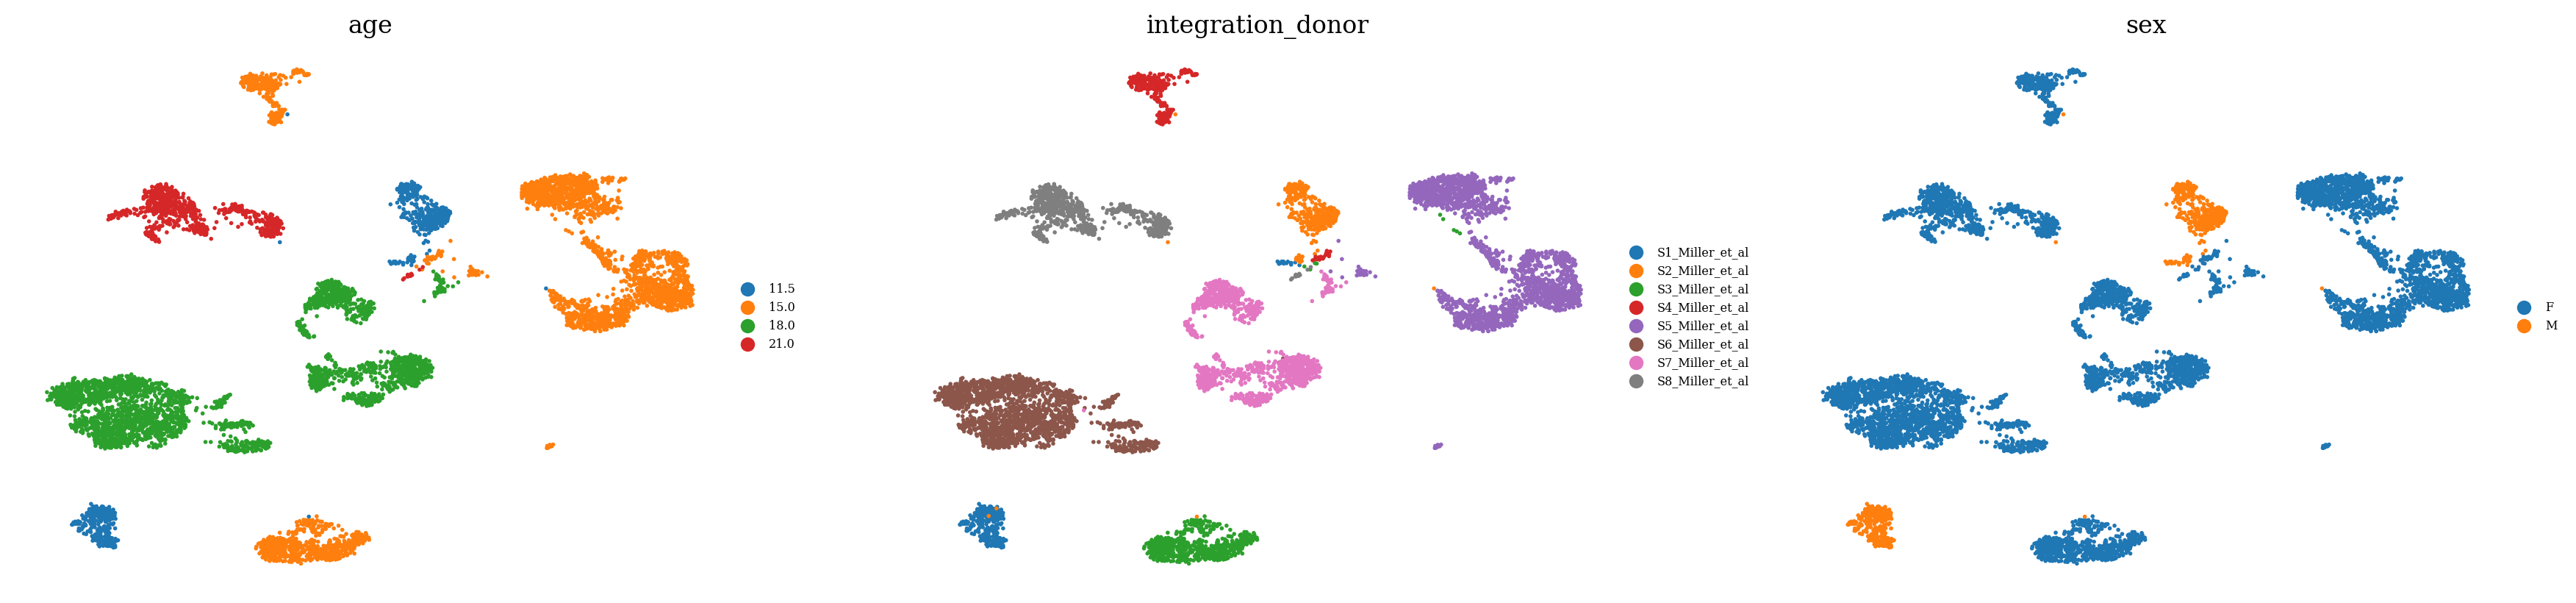

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

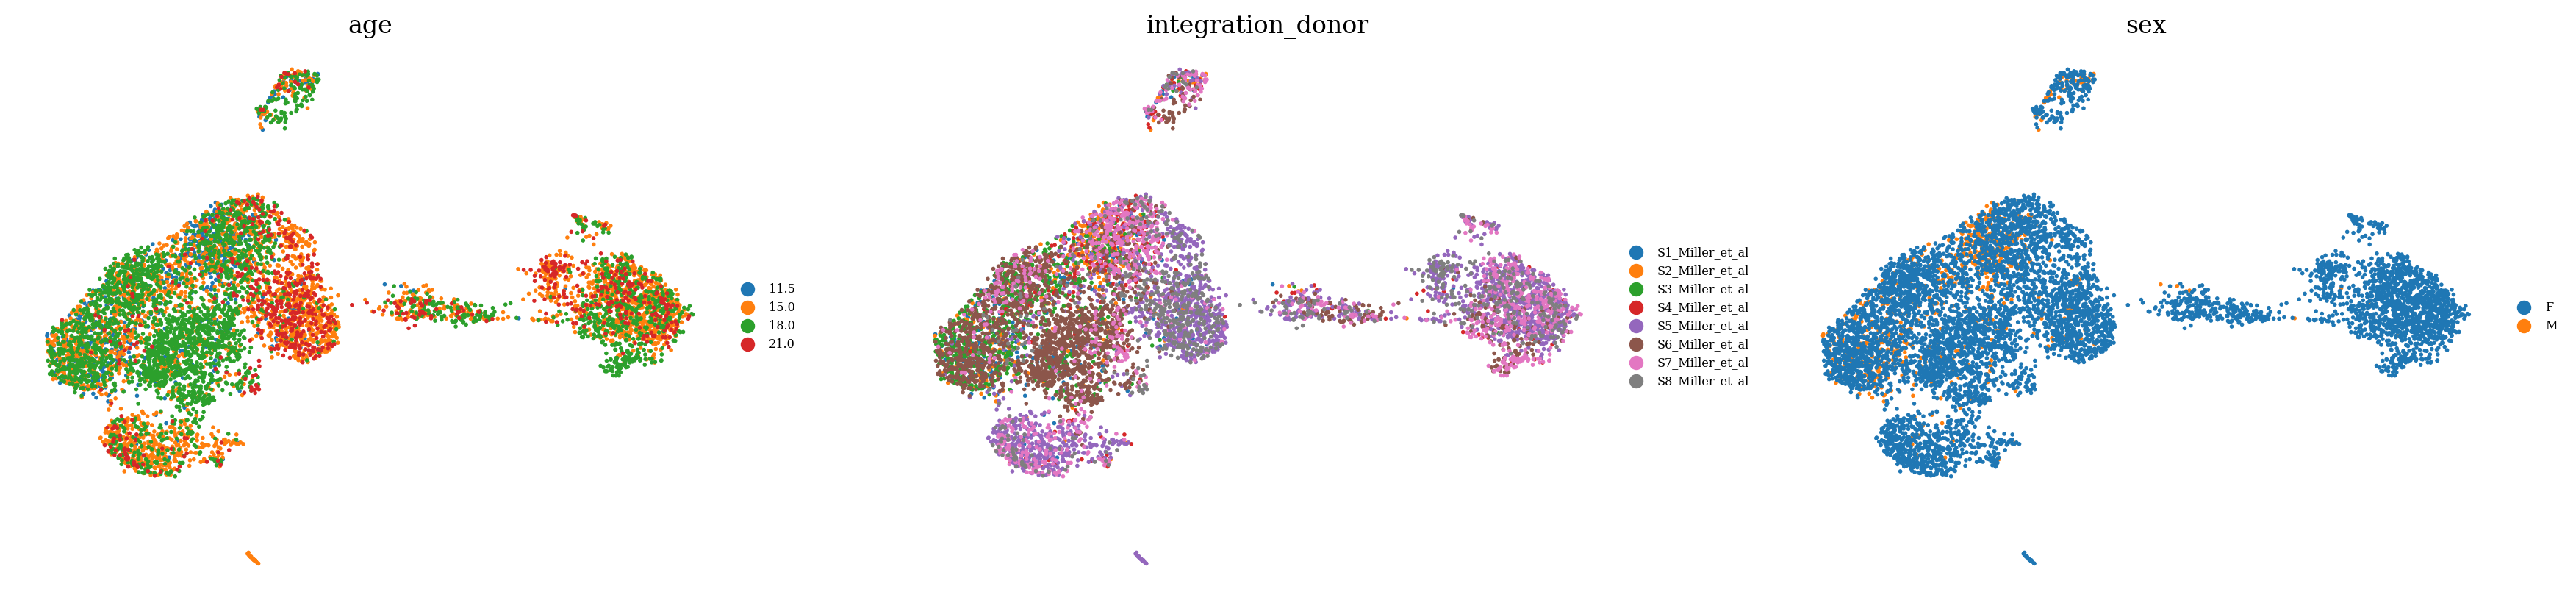

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<02:37,  1.47it/s]

  8%|▊         | 19/232 [00:00<00:06, 32.29it/s]

 15%|█▍        | 34/232 [00:00<00:03, 55.39it/s]

 20%|██        | 47/232 [00:01<00:02, 63.23it/s]

 25%|██▌       | 58/232 [00:01<00:02, 71.94it/s]

 32%|███▏      | 75/232 [00:01<00:01, 93.82it/s]

 41%|████      | 94/232 [00:01<00:01, 117.57it/s]

 49%|████▊     | 113/232 [00:01<00:00, 136.37it/s]

 57%|█████▋    | 133/232 [00:01<00:00, 151.88it/s]

 66%|██████▌   | 153/232 [00:01<00:00, 163.09it/s]

 75%|███████▍  | 173/232 [00:01<00:00, 171.45it/s]

 83%|████████▎ | 193/232 [00:01<00:00, 177.04it/s]

 92%|█████████▏| 213/232 [00:01<00:00, 181.03it/s]

100%|██████████| 232/232 [00:02<00:00, 163.16it/s]

100%|██████████| 232/232 [00:02<00:00, 108.42it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.2901819331289491

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)